In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_peaks = pd.read_pickle("../data/processed/df_peaks_fp.pkl")
print(df_peaks.head())
df_filter = pd.read_pickle("../data/processed/df_filter.pkl")
print(df_filter.head())

  record_id                                             signal   age  \
0   JS00001  [-0.254, -0.254, -0.254, -0.254, -0.264, -0.27...  85.0   
1   JS00002  [-0.01, -0.024, -0.02, 0.01, 0.01, -0.029, -0....  59.0   
2   JS00004  [0.195, 0.195, 0.195, 0.195, 0.176, 0.166, 0.1...  66.0   
3   JS00005  [0.005, 0.005, -0.015, -0.005, -0.005, -0.049,...  73.0   
4   JS00006  [-0.029, -0.029, -0.029, -0.029, -0.034, -0.03...  46.0   

        diagnosticos                                            r_peaks  \
0  [AFIB, RBBB, TWC]                                  [345, 2167, 4063]   
1          [SB, TWC]    [541, 1112, 1680, 2279, 2853, 3449, 4013, 4604]   
2               [SB]  [404, 973, 1522, 2086, 2645, 3197, 3768, 4339,...   
3   [AF, STDD, STTC]  [160, 343, 527, 719, 907, 1091, 1275, 1457, 16...   
4               [SB]  [221, 759, 1287, 1797, 2340, 2877, 3404, 3918,...   

     rr_std     rr_cv     pnn50  male  
0  0.074000  0.019903  0.500000     1  
1  0.026766  0.023057  0.571429     

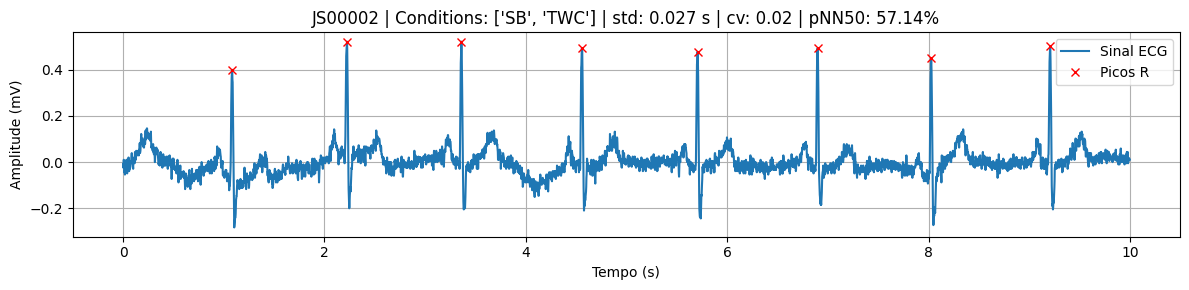

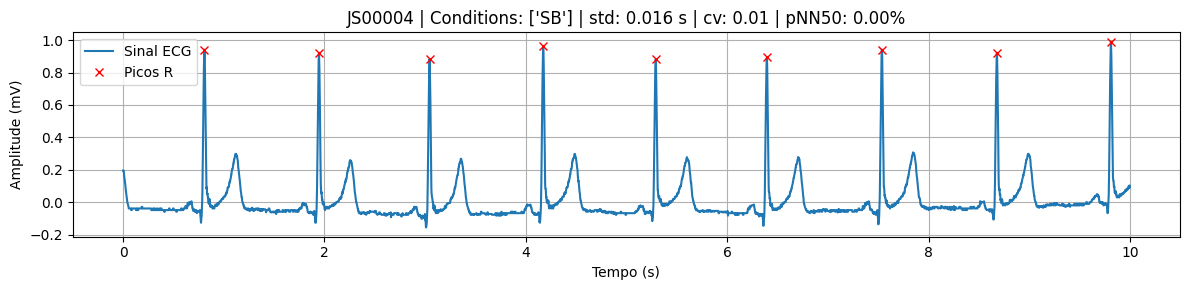

In [3]:
fs = 500

for i in range(2):
    sinal = df_peaks.iloc[i]["signal"]
    tempo = np.arange(len(sinal)) / fs
    r_peaks = df_peaks.iloc[i]["r_peaks"]

    # Métricas RR
    rr_std = df_peaks.iloc[i]["rr_std"]
    rr_cv = df_peaks.iloc[i]["rr_cv"]
    pnn50 = df_peaks.iloc[i]["pnn50"]

    # Título com as métricas
    titulo = (
        f"{df_peaks.iloc[i]['record_id']} | Conditions: {df_peaks.iloc[i]['diagnosticos']} | "
        f"std: {rr_std:.3f} s | cv: {rr_cv:.2f} | pNN50: {pnn50:.2%}"
        if rr_std is not None else f"{df_peaks.iloc[i]['record_id']} | Dados insuficientes"

    )

    # Plot
    plt.figure(figsize=(12, 3))
    plt.plot(tempo, sinal, label="Sinal ECG")
    if len(r_peaks) > 0:
        plt.plot(np.array(r_peaks) / fs, np.array(sinal)[r_peaks], "rx", label="Picos R")

    plt.title(titulo)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
from sklearn.model_selection import train_test_split

print('df_peaks', df_peaks.shape)

df_ml = df_peaks[["rr_std", "rr_cv", "pnn50", "diagnosticos"]].copy()
df_ml["tem_afib"] = df_ml["diagnosticos"].apply(lambda x: "AFIB" in x).astype(int)
df_ml = df_ml.dropna(subset=["rr_std", "rr_cv", "pnn50"])
print("Amostras com métricas válidas:", len(df_ml))

# Print casos com e sem AFIB
print("Casos com AFIB:", df_ml["tem_afib"].sum())
print("Casos sem AFIB:", len(df_ml) - df_ml["tem_afib"].sum())

X = df_ml[["rr_std", "rr_cv", "pnn50"]]
y = df_ml["tem_afib"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



df_peaks (45150, 9)
Amostras com métricas válidas: 43261
Casos com AFIB: 1687
Casos sem AFIB: 41574


In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

modelos = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"{nome}\n", classification_report(y_test, y_pred))


Logistic Regression
               precision    recall  f1-score   support

           0       0.99      0.74      0.85      8316
           1       0.12      0.88      0.21       337

    accuracy                           0.75      8653
   macro avg       0.56      0.81      0.53      8653
weighted avg       0.96      0.75      0.83      8653

SVM
               precision    recall  f1-score   support

           0       1.00      0.73      0.85      8316
           1       0.13      0.96      0.22       337

    accuracy                           0.74      8653
   macro avg       0.56      0.84      0.54      8653
weighted avg       0.96      0.74      0.82      8653

Random Forest
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      8316
           1       0.09      0.04      0.05       337

    accuracy                           0.95      8653
   macro avg       0.52      0.51      0.51      8653
weighted avg       0.93      0.95

In [5]:
from sklearn.model_selection import train_test_split

print('df_filter', df_filter.shape)

df_ml = df_filter[["rr_std", "rr_cv", "pnn50", "diagnosticos"]].copy()
df_ml["tem_afib"] = df_ml["diagnosticos"].apply(lambda x: "AFIB" in x).astype(int)
df_ml = df_ml.dropna(subset=["rr_std", "rr_cv", "pnn50"])
print("Amostras com métricas válidas:", len(df_ml))

# Print casos com e sem AFIB
print("Casos com AFIB:", df_ml["tem_afib"].sum())
print("Casos sem AFIB:", len(df_ml) - df_ml["tem_afib"].sum())

X = df_ml[["rr_std", "rr_cv", "pnn50"]]
y = df_ml["tem_afib"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



df_filter (40836, 9)
Amostras com métricas válidas: 40836
Casos com AFIB: 1567
Casos sem AFIB: 39269


In [6]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

modelos = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print(f"{nome}\n", classification_report(y_test, y_pred))

Logistic Regression
               precision    recall  f1-score   support

           0       1.00      0.74      0.85      7855
           1       0.12      0.91      0.22       313

    accuracy                           0.75      8168
   macro avg       0.56      0.83      0.53      8168
weighted avg       0.96      0.75      0.82      8168

SVM
               precision    recall  f1-score   support

           0       1.00      0.73      0.85      7855
           1       0.13      0.97      0.22       313

    accuracy                           0.74      8168
   macro avg       0.56      0.85      0.53      8168
weighted avg       0.97      0.74      0.82      8168

Random Forest
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      7855
           1       0.23      0.05      0.08       313

    accuracy                           0.96      8168
   macro avg       0.60      0.52      0.53      8168
weighted avg       0.94      0.96